
<font size = "5"> **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# HW5:  Analyzing CBED Pattern

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Diffraction/CH2_HW5-CBED.ipynb)
 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Diffraction/CH2_HW5-CBED.ipynb)



part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2021

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes


## Load relevant python packages
### Check Installed Packages

In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install pyTEMlib -q
# pyTEMlib setup ------------------
else:
    if test_package('pyTEMlib') < '0.2021.2.5':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

done


### Import numerical and plotting python packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,

and some libraries from the book
* kinematic scattering library.
* file_tools library

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
import sys
if 'google.colab' in sys.modules:
    %pylab --no-import-all inline
else:
    %pylab --no-import-all notebook
    %gui qt

# additional package 
import  itertools 
import scipy.constants as const

import ipywidgets as ipyw

# Import libraries from the book

# Import libraries from pyTEMlib
import pyTEMlib
import pyTEMlib.kinematic_scattering as ks         # Kinematic sCattering Library
                             # Atomic form factors from Kirklands book

### And we use the image tool library of Quantifit
import pyTEMlib.file_tools as ft
import pyTEMlib
print(pyTEMlib.__version__)

Populating the interactive namespace from numpy and matplotlib
Using kinematic_scattering library version  0.6  by G.Duscher
spglib not installed; Symmetry functions of spglib disabled
0.2021.03.17


C:\Users\gduscher\Anaconda3\lib\site-packages\pyUSID\viz\__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '


## Load CBED Pattern
>
>Please note, that this notebook will not work in Google colab becaus of the ``open file dialog``
>
First we select the diffraction pattern

Cannot overwrite file. Using:  CBED_375mm_alpha_3.3_beta9.6_Condensor10um_Filter-2.hf5


C:\Users\gduscher\Anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:351: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


<IPython.core.display.Javascript object>


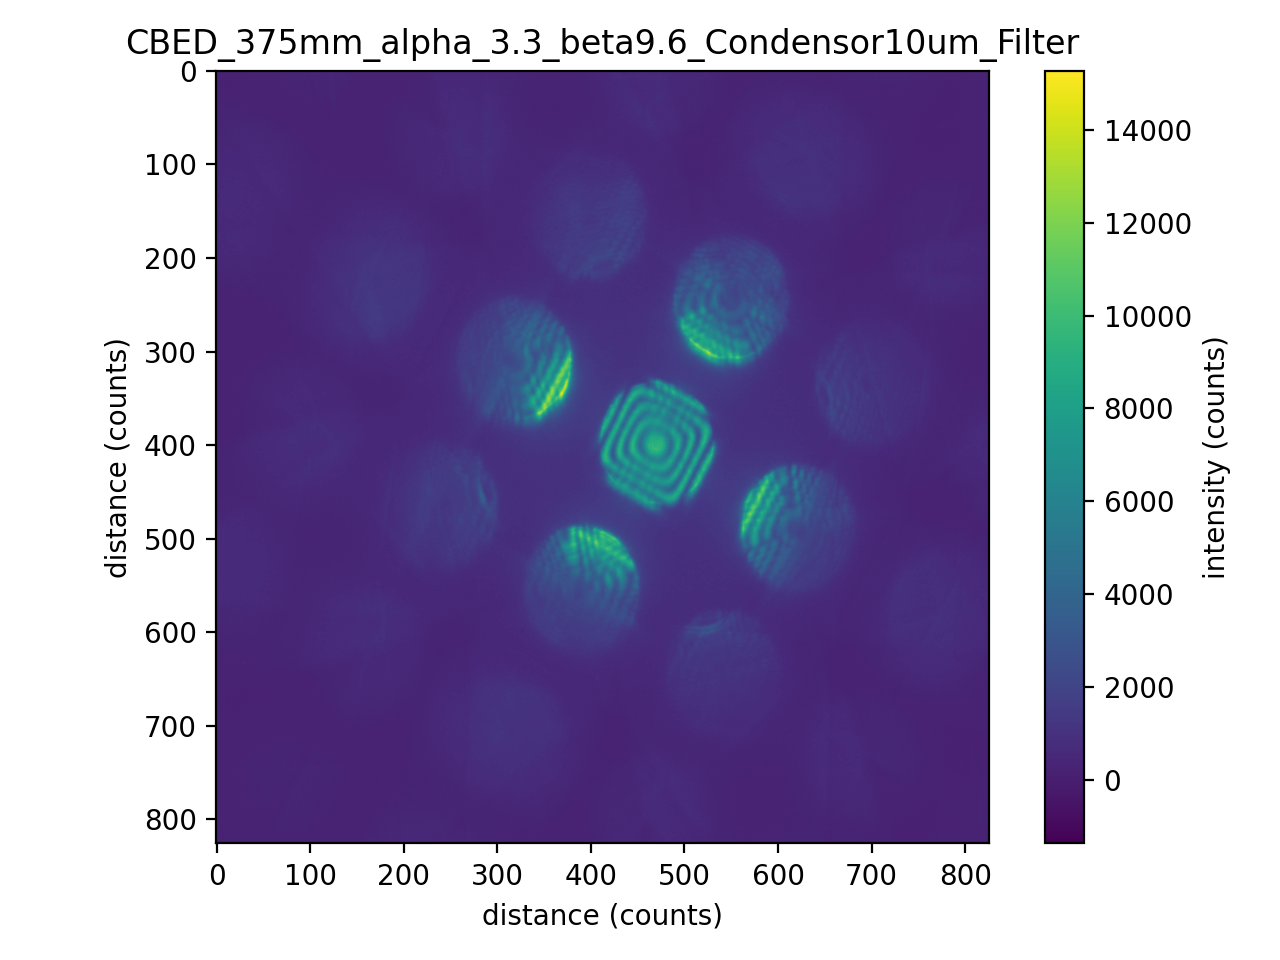

In [57]:
try:
    sidpy_dataset.h5_dataset.file.close()  #close old file if it exists before open a new one
except:
    pass
sidpy_dataset = ft.open_file()
sidpy_dataset.plot()

### Plotting on a logarithmic scale

The dynamic range in diffraction data is even larger than in images and so for a good presentation of the data it is advantagous to go to plot the intensities in a logarythmic scale.

To present data in logarythmic scale no nexgative values (noise) can be in these data and so all negative values in the dataset will be set to zero.

The factor 1 in front of the diffraction pattern in the log numpy function in the ``imshow`` is the gamma value.
Changing that value will change the contrast.

[-0.2016160637140274, 825.6177809089422, 825.6177809089422, -0.2016160637140274]


<IPython.core.display.Javascript object>


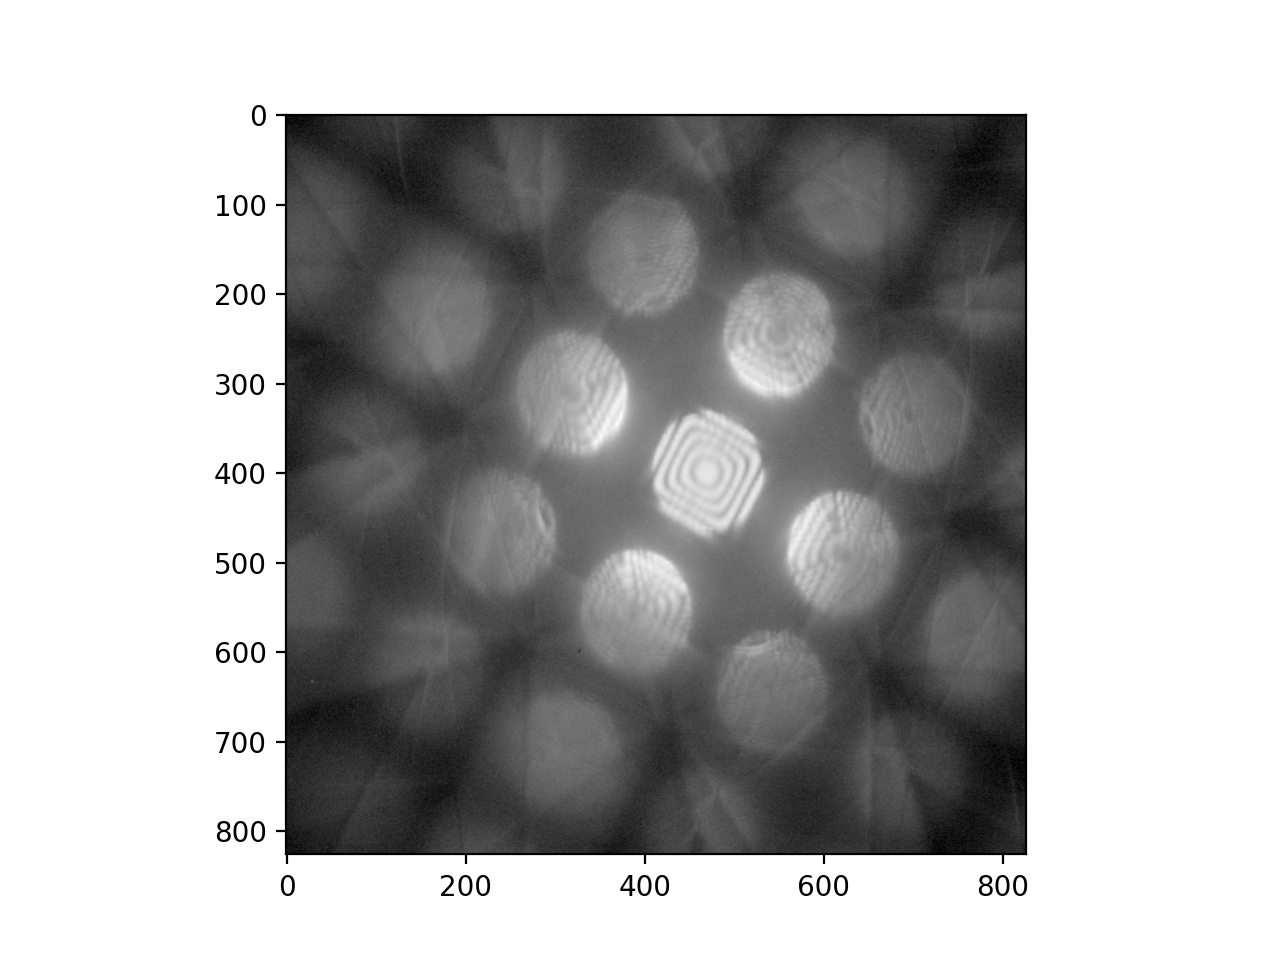

In [34]:
diff_pattern = np.array(sidpy_dataset).T
diff_pattern[diff_pattern<0] = 0.
extent = sidpy_dataset.get_extent([0,1])
print(extent)
fig = plt.figure() 
plt.imshow(np.log(1+diff_pattern),cmap="gray", vmin=np.max(np.log(1+diff_pattern))*0.5, extent=extent);





First try with cross correlation of rotated images


## Finding the center

### Selection of  center disk

Select the center disk with the ring selector


<IPython.core.display.Javascript object>


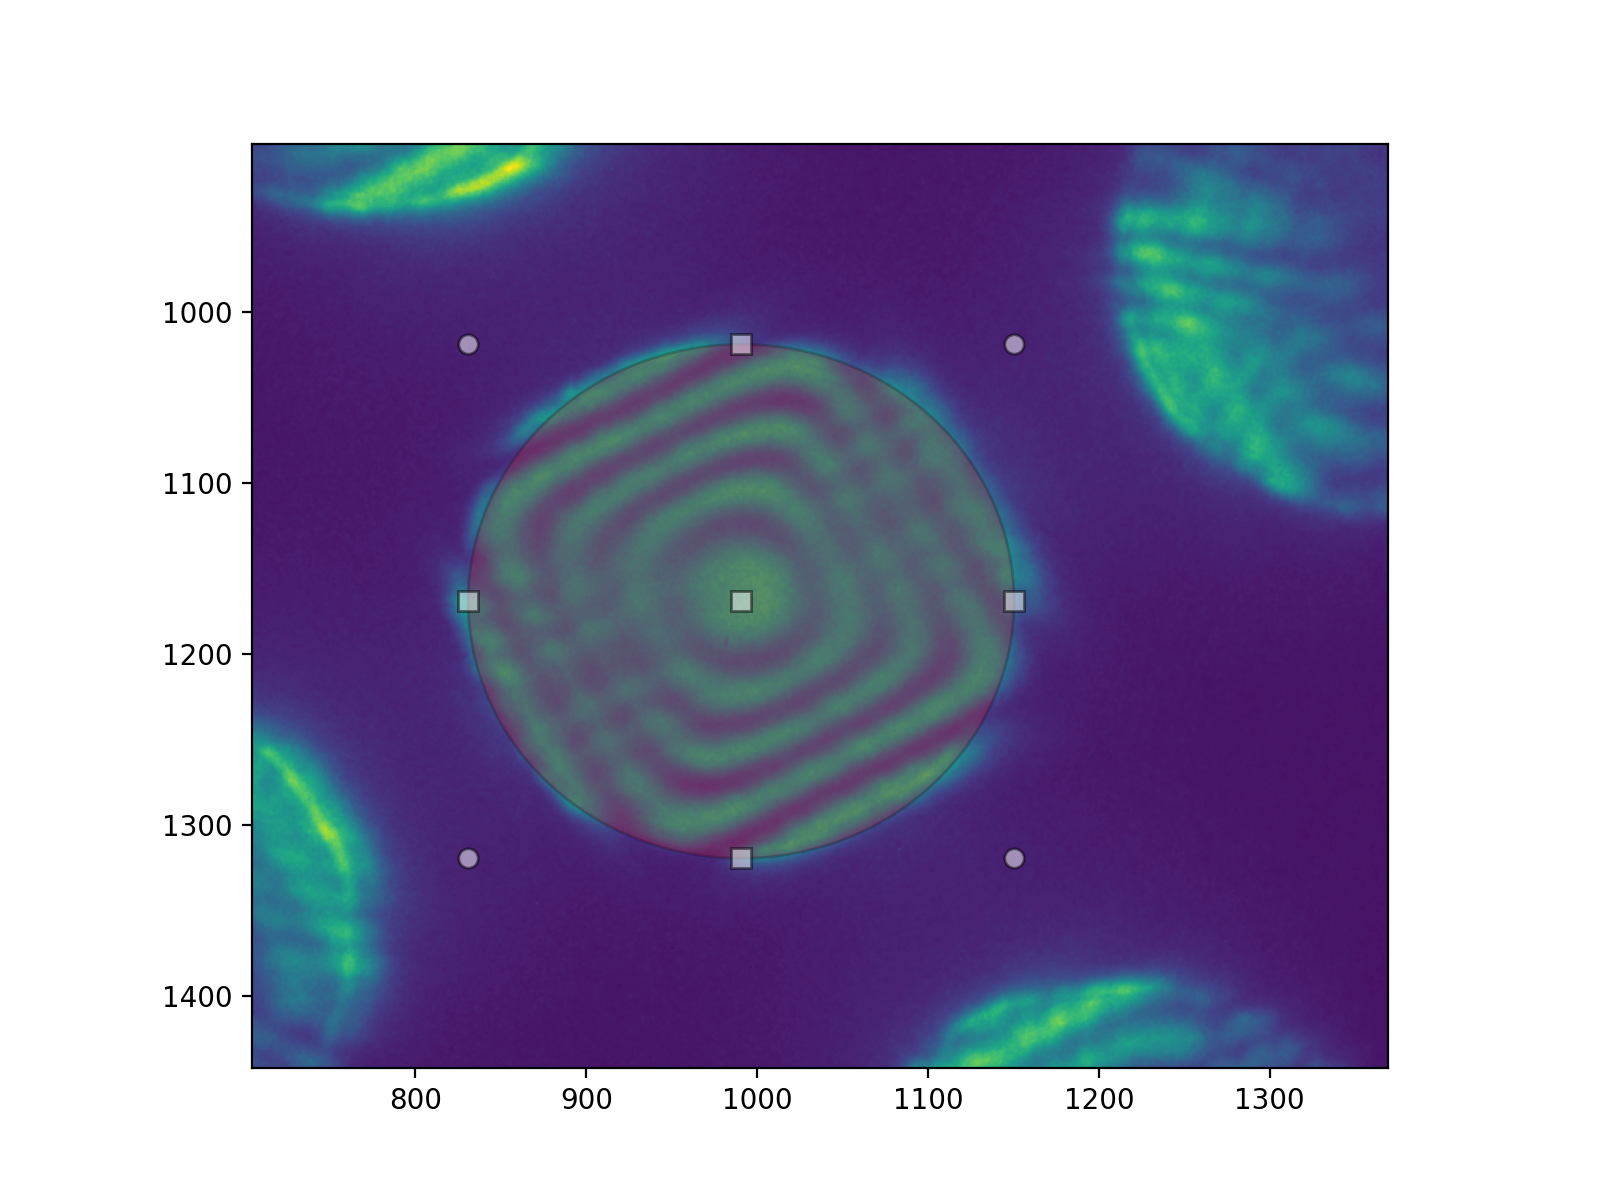

In [49]:
from matplotlib.widgets import  EllipseSelector


center = np.array([1024,1024])

plt.figure(figsize=(8, 6))
plt.imshow(diff_pattern.T, origin = 'upper')
selector = EllipseSelector(plt.gca(), None,interactive=True , drawtype='box')  # gca get current axis (plot)

selector.to_draw.set_visible(True)
radius = 559 
center = np.array(center)

selector.extents = (center[0]-radius,center[0]+radius,center[1]-radius,center[1]+radius)


### Read out center and radius

In [50]:
xmin, xmax, ymin, ymax = selector.extents
x_center, y_center = selector.center
x_shift = x_center - diff_pattern.shape[0]/2
y_shift = y_center - diff_pattern.shape[1]/2
print(f'radius x-direction = {(xmax-xmin)/2:.0f} pixels')
print(f'radius y-direction = {(ymax-ymin)/2:.0f} pixels')

center = (x_center, y_center )
print(f'new center = {center} [pixels]')

out_tags ={}
out_tags['center'] = center

radius x-direction = 160 pixels
radius y-direction = 150 pixels
new center = (990.65783091818, 1169.2512643831637) [pixels]


## Calculate Spot Pattern

see [Plotting of Diffraction Pattern](Plotting_Diffraction_Pattern.ipynb) for details


In [51]:
#Initialize the dictionary of the input
tags_simulation = {}
### Define Crystal
tags_simulation  = ks.structure_by_name('silicon')

### Define experimental parameters:
tags_simulation['acceleration_voltage_V'] = 200.0 *1000.0 #V
tags_simulation['new_figure'] = False
tags_simulation['plot FOV'] = 30
tags_simulation['convergence_angle_mrad'] = 0
tags_simulation['zone_hkl'] = np.array([0,0,1])  # incident neares zone axis: defines Laue Zones!!!!
tags_simulation['mistilt']  = np.array([0,0,0])  # mistilt in degrees
tags_simulation['Sg_max'] = .4 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags_simulation['hkl_max'] = 15   # Highest evaluated Miller indices

######################################
# Diffraction Simulation of Crystal #
######################################

ks.kinematic_scattering(tags_simulation, verbose = True)


reciprocal_unit_cell
[[1.764 0.    0.   ]
 [0.    1.764 0.   ]
 [0.    0.    1.764]]
The inner potential is 318.2V
Using an acceleration voltage of 200.0kV
Magnitude of incident wave vector in material: 399.1 1/nm and in vacuum: 398.7 1/nm
Which is an wave length of 2.505 pm in the material and 2.508 pm in the vacuum
The convergence angle of 0.0mrad = 0.00 1/nm
Magnitude of incident wave vector in material: 399.1 1/nm which is a wavelength 2.505 pm
Center of Ewald sphere  [  0.           0.         399.13341778]
Of the 29790 tested reciprocal_unit_cell points, 364 have an excitation error less than 0.40 1/nm
Of the 364 possible reflection 48 are allowed.
Of the 316 forbidden reflection 0 can be dynamcially activated.
[]
Laue_circle [0. 0. 0.]
 There are 36 allowed reflections in the zero order Laue Zone
 There are 12 allowed reflections in the first order Laue Zone
 There are 0 allowed reflections in the second order Laue Zone
 There are 0 allowed reflections in the higher order Laue Z

## Plotting Experimental and Simulated Spot Diffraction Patterns

There is a problem with those diffraction pattern and they did not store the scale.
So I am using an approximate one and you'll have to change that.

Scale is 0.0115 1/nm


<IPython.core.display.Javascript object>


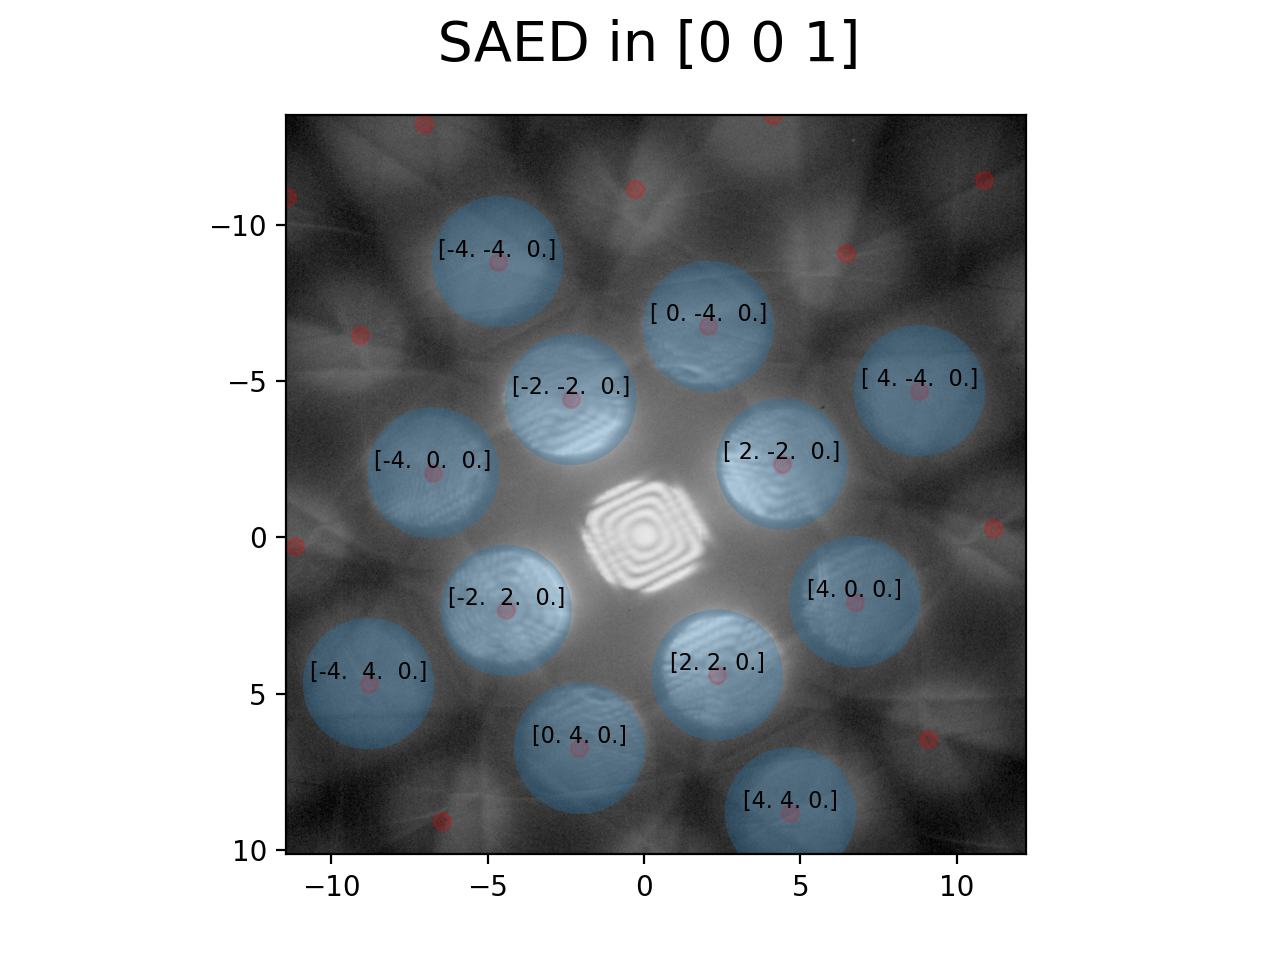

In [64]:
# ----- Input ---------
rotation_angle = -0  # in degrees
convergence_angle = 1.0  # in 1/nm
change_of_scale = 100    # in  %
# -------------------


scale_300mm = 0.012829394079744816

# g = gx = gy = ft.get_slope(sidpy_dataset.x.values) # does not work here

g = gx = gy = scale_300mm * change_of_scale/100.0

print(f'Scale is {g:.4f} 1/nm per pixel')
extent= np.array([-center[0]*gx, (diff_pattern.shape[0]-center[0])*gx,(diff_pattern.shape[1]-center[1])*gy, -center[1]*gy])

# rotation matrix  around z axis to coincide with spots
angle = np.radians(rotation_angle)
c = np.cos(angle)
s = np.sin(angle)
r_mat = np.array([[c,-s,0],[s,c,0],[0,0,1]])
rotation_matrix = r_mat


spots_simulation =  np.dot(tags_simulation['allowed']['g'], rotation_matrix)
spots_ZOLZ = spots_simulation[tags_simulation['allowed']['ZOLZ']]
fig = plt.figure()
fig.suptitle(' SAED in ' + str(tags_simulation['zone_hkl']), fontsize=20) 
plt.scatter(spots_ZOLZ[:,0], spots_ZOLZ[:,1], c='red',  alpha = 0.2,   label='spots')
plt.imshow(np.log2(1+diff_pattern).T,cmap="gray", extent=(extent), vmin=np.max(np.log2(1+diff_pattern))*0.5);

for i in range(len(tags_simulation['allowed']['g'])):
    if np.linalg.norm(tags_simulation['allowed']['g'][i]) <10:
        disk = plt.Circle((spots_simulation[i,0], spots_simulation[i,1] ), convergence_angle, alpha=0.3)
        plt.gca().add_artist(disk) 
        plt.text(spots_simulation[i,0], spots_simulation[i,1],str(tags_simulation['allowed']['hkl'][i]),
                fontsize = 8, horizontalalignment = 'center', verticalalignment ='bottom')
    

### What does the above figure convey?




### What is the accuracy?




## Conclusion

We need more information for the spot pattern than for the ring pattern.

The convergent beam pattern has the same kinematic diffradciton information but provides additional dynamical diffraction information.

A comparison between simulation and experiment can be very precise.

In principle, if you have the spots and the approximate center you can let an optimization routine do all the scaling for you (which we will do in the high resultion imaging section).

